In [61]:
from read import ReadData, CubeLoader
from sklearn.pipeline import Pipeline
from median import Picker
from lib.cubes import Cubes
from scalers import Gradient, Standard
from cv_runner import CVRunner
from process import PrepData, PrepModel, Downsample, PCARunner, Cutter, TrainTestSelector
from classifier import Classifier, Creator, KNNClassifier, XGBoostClassifier #, TpotClassifier
from results import Collector, Writer, Pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, LeakyReLU, ELU, ReLU
import keras.optimizers as opt
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard
import os
from persist import Persistance
from model_create import ModelCreate
from model_runner import ModelRunner
from filters import SavgolFilter, NdviFilter, McariFilter, SoilFilter, AMFilter, LinearTransform
from features import FeatureSelect

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt

import numpy as np
import hashlib

from lib.pipeline2dot import pipeline2dot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [62]:
# Iš kur imam pradinius duomenis (meta ir bazinį neapdorotą datasetą)
folder = '/data/hypersp/datasets/Kvieciai'
result_folder = f'{folder}/RawSveikiAugalai/'
data_folder = f'{folder}'
Augalas = 'žieminiai kviečiai'

In [63]:
dr = ReadData(Augalas, data_folder, data_folder, metadata_filename='raw_data.csv')

In [64]:
# užkrauna duomenis į data masyvą (read_cube_data = False neskaito iš tikro duomenų)
data = dr.load(read_cube_data = False)

Loading samples from /data/hypersp/datasets/Kvieciai/raw_data.csv
Samples from ['index' 'Lauko savininkas' 'Vietovė' 'Augalas' 'Veislė' 'Data' 'Mėginys'
 'Kubas' 'N' 'K' 'Ca' 'Mg' 'P' 'S' 'Cu' 'Fe' 'Zn' 'Mn' 'Na' 'B' 'Mo' 'N'
 'K' 'Ca' 'Mg' 'P' 'S' 'Cu' 'Fe' 'Zn' 'Mn' 'B' 'Mo' 'x1' 'y1' 'x2' 'y2'
 'x3' 'y3' 'x4' 'y4']
indx (1309,)
meta (1309, 7) of ['Lauko savininkas' 'Vietovė' 'Augalas' 'Veislė' 'Data' 'Mėginys' 'Kubas']
comp (1309, 13) of ['N' 'K' 'Ca' 'Mg' 'P' 'S' 'Cu' 'Fe' 'Zn' 'Mn' 'Na' 'B' 'Mo']
klas (1309, 12) of ['N' 'K' 'Ca' 'Mg' 'P' 'S' 'Cu' 'Fe' 'Zn' 'Mn' 'B' 'Mo']
coor (1309, 8) of ['x1' 'y1' 'x2' 'y2' 'x3' 'y3' 'x4' 'y4']
Saved samples to /data/hypersp/datasets/Kvieciai/raw_data.csv


In [65]:
l = []
for a in np.unique(data[1].meta[:,[0,1,4]], axis = 0):
    l.append(' '.join(a[a != '']))
group_names = np.array(l)

## NN Version 1

0.72 max, 0.70 stable in 160 epochs

In [52]:
nn_input = 192
nn_output = 2
elu_alpha = 0.2

def get_model():

    model = Sequential()

    model.add(Dense(nn_input, input_dim = nn_input, name = 'dense1', 
                    kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5),
                    kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())
    #model.add(ELU(alpha = elu_alpha))
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(nn_input // 2, name = 'dense2', 
                    kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    #model.add(ELU(alpha = elu_alpha))
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(nn_input // 4, name = 'dense3', 
                    kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(ELU(alpha = elu_alpha))
    #model.add(ReLU())
    model.add(Dropout(0.5))

    # model.add(Dense(nn_input // 4, name = 'dense4', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(ELU(alpha = elu_alpha))
    # model.add(Dropout(0.5))

    # model.add(Dense(nn_input // 5, name = 'dense5', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(ELU(alpha = elu_alpha))
    # model.add(Dropout(0.5))

    model.add(Dense(nn_output, activation = 'softmax', name = 'softmax'))

    model.summary()

    epochs = 150
    learning_rate = 0.001
    decay_rate = 1e-6
    momentum_rate = 0.9

    optim = opt.SGD(lr = learning_rate, decay = decay_rate, momentum = momentum_rate, nesterov = False)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optim, metrics = ['accuracy'])

    es = EarlyStopping(monitor='loss', min_delta = 0,
                       patience = 10, verbose = 0, restore_best_weights = True)

    tb = TensorBoard(log_dir = 'logs', histogram_freq = 1)
    
    return model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 192)               37056     
_________________________________________________________________
batch_normalization_1 (Batch (None, 192)               768       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 192)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)               0         
_________________________________________________________________
dense2 (Dense)               (None, 96)                18528     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96)                384       
__________________________

## Dirbame

In [92]:
nn_input = 192
nn_output = 1
elu_alpha = 0.2

epochs = 5
learning_rate = 0.001
decay_rate = 1e-6
momentum_rate = 0.9

def get_model():

    model = Sequential()

    model.add(Dense(nn_input, input_dim = nn_input, name = 'dense1', 
                    kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5),
                    kernel_initializer = 'he_normal'))
    model.add(BatchNormalization())
    #model.add(ELU(alpha = elu_alpha))
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(nn_input // 2, name = 'dense2', 
                    kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    #model.add(ELU(alpha = elu_alpha))
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(nn_input // 4, name = 'dense3', 
                    kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                    bias_regularizer = regularizers.l2(1e-4),
                    activity_regularizer = regularizers.l2(1e-5),
                    kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(ELU(alpha = elu_alpha))
    #model.add(ReLU())
    model.add(Dropout(0.5))

    # model.add(Dense(nn_input // 4, name = 'dense4', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(ELU(alpha = elu_alpha))
    # model.add(Dropout(0.5))

    # model.add(Dense(nn_input // 5, name = 'dense5', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(ELU(alpha = elu_alpha))
    # model.add(Dropout(0.5))

    model.add(Dense(nn_output, activation = 'sigmoid', name = 'output'))

    # model.summary()

    optim = opt.SGD(lr = learning_rate, decay = decay_rate, momentum = momentum_rate, nesterov = False)
    model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

#     es = EarlyStopping(monitor='loss', min_delta = 0,
#                        patience = 10, verbose = 0, restore_best_weights = True)

#     tb = TensorBoard(log_dir = 'logs', histogram_freq = 1)
    
    return model

In [67]:
tts = TrainTestSelector(data[1], data[2], 13, 'N', 
                        None, job_type='fields', sampler = 'none', transform_type = 'binary', conv=False)
tts.fit(('N', 1));
X = np.load('/data/hypersp/datasets/Kvieciai/RawSveikiAugalai/raw-data-1000.npy')
x_train, y_train, x_valid, y_valid, x_test, y_test, n_test = tts.transform(X)

(954000, 192) (18000, 192)


In [76]:
x_train = np.append(x_train, x_valid, axis=0)
y_train = np.append(y_train, y_valid, axis=0)[:,np.newaxis]
y_test = y_test[:,np.newaxis]

In [83]:
model = get_model()
log = model.fit(x_train, y_train,
    batch_size = 512,
    epochs = 1,
    shuffle = True,
    verbose = 2,
    #callbacks = [ es, tb ],
    validation_data=(x_test, y_test)
)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 192)               37056     
_________________________________________________________________
batch_normalization_19 (Batc (None, 192)               768       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 192)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense2 (Dense)               (None, 96)                18528     
_________________________________________________________________
batch_normalization_20 (Batc (None, 96)                384       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 96)               

In [84]:
model.evaluate(x_test, y_test)

18000/18000 [==============================] - 1s 46us/step


[0.7721123957104153, 0.5918333530426025]

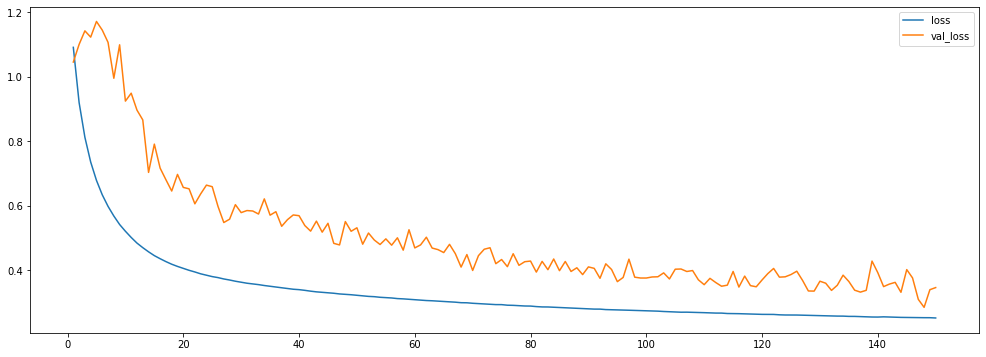

In [116]:
xepochs = range(1, len(log.history['loss']) + 1)
plt.rcParams['figure.figsize'] = (17, 6)
plt.plot(xepochs, log.history['loss'], label = 'loss')
plt.plot(xepochs, log.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

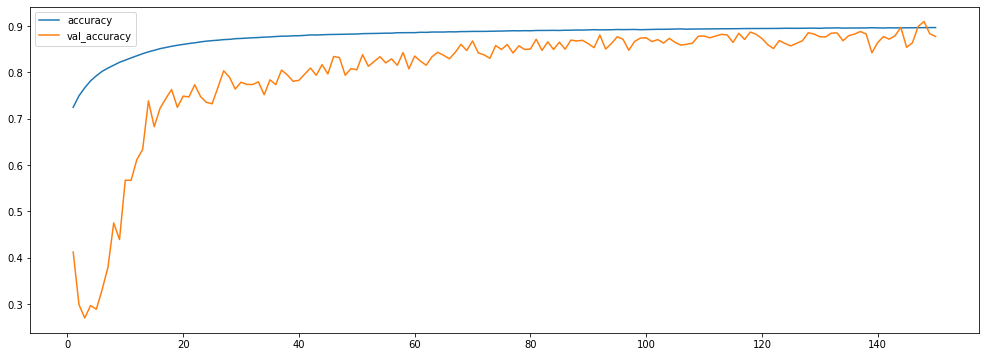

In [117]:
plt.rcParams['figure.figsize'] = (17, 6)
plt.plot(xepochs, log.history['accuracy'], label = 'accuracy')
plt.plot(xepochs, log.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [104]:
model.save('model/elN_field1_v01.hdf') 

In [44]:
import csv, numpy as np
import matplotlib.pyplot as plt

with open('/data/hypersp/datasets/Kvieciai/Rezultatai/RawNNv3_hist/nn_N_4.csv') as f:
    reader = csv.reader(f)
    hheader = np.array(next(reader))
    hdata = np.array(list(reader), dtype = float)

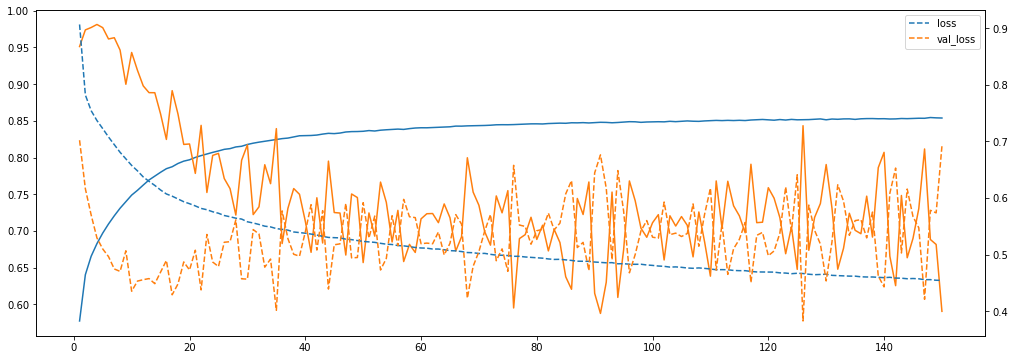

No handles with labels found to put in legend.


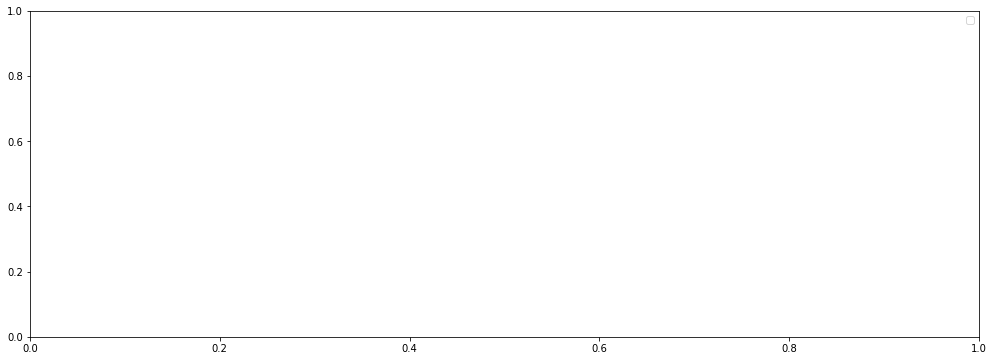

In [45]:
plt.rcParams['figure.figsize'] = (17, 6)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(hdata[:,0] + 1, hdata[:,4], label = 'accuracy')
ax1.plot(hdata[:,0] + 1, hdata[:,2], label = 'val_accuracy')
ax2.plot(hdata[:,0] + 1, hdata[:,3], '--', label = 'loss')
ax2.plot(hdata[:,0] + 1, hdata[:,1], '--', label = 'val_loss')
plt.legend()
plt.show()


# ax1.plot(x, y1, 'g-')
# ax2.plot(x, y2, 'b-')

# ax1.set_xlabel('X data')
# ax1.set_ylabel('Y1 data', color='g')
# ax2.set_ylabel('Y2 data', color='b')

# plt.rcParams['figure.figsize'] = (17, 6)
# plt.plot(hdata[:,0] + 1, hdata[:,3], label = 'loss')
# plt.plot(hdata[:,0] + 1, hdata[:,1], label = 'val_loss')
plt.legend()
plt.show()

In [34]:
# Kur deti rezultatus
result_out_folder = '/data/hypersp/datasets/Kvieciai/Rezultatai'
res_folder = f'{result_out_folder}/RawNN2'
wavelength = Cubes().wavelength

# Picker skirtas sukurti apdorotam datasetui, bet jis jau yra tai tiesiog nuskaitys i atminti
picker = Picker(result_folder, n_jobs=1, overwrite_files = False, spec_take = 1, spec_number = 1000,
                result_file_name = 'raw-data-1000.npy', iterations = 1000*2, add_soil = False)

# sukuriam CV runner su nuskaitytais duomenim
cvrunner = CVRunner(data[3], data[1], data[2],
                    result_folder=os.path.join(result_folder, res_folder), n_jobs = 1)

# skirtas CV duomenu paruosimui. keep_elems nurodo kokius elementus tirsim. 
# conv reikia jei konvoliucinis tinklas naudojamas
cvrunner.add_step('dataprep', PrepData(data[1], data[2], job_type='fields', sampler = 'under',
                                       transform_type = 'ohe', Augalas = Augalas, keep_elems=['N'], conv=False))

# sukuriam klasifikatoriu pagal model ir earlyStopping (es), 
# history_folder saugos training'o istorija, jei nereikia none palikt
cvrunner.add_step('classify', Classifier(model, [ es ], epochs=150, verbose=1, 
                                         history_folder=f'{result_out_folder}/RawNN1_hist'))

# surenka klasifikavimo rezultata
cvrunner.add_step('collect', Collector(result_folder=res_folder))

# gauta rezultata i csv iraso
cvrunner.add_step('write', Writer(data[1], add_metrics_to_csv=True,
                                  result_folder=res_folder,
                                  job_type='fields', Augalas = Augalas))

union = Pipeline([('pikcer', picker), # nuskaito dataseta
                  ('cv', cvrunner) # leidzia CV pagal grupes arba laukus
                 ])

X = union.transform(data[0])

no test size
Train on 451200 samples, validate on 112800 samples
Epoch 1/150
451200/451200 [==============================] - 2s 5us/step - loss: 0.5458 - accuracy: 0.7278 - val_loss: 0.4971 - val_accuracy: 0.7657
Epoch 2/150
451200/451200 [==============================] - 2s 5us/step - loss: 0.4639 - accuracy: 0.7861 - val_loss: 0.4280 - val_accuracy: 0.8048
Epoch 3/150
451200/451200 [==============================] - 2s 5us/step - loss: 0.4009 - accuracy: 0.8187 - val_loss: 0.3959 - val_accuracy: 0.8129
Epoch 4/150
451200/451200 [==============================] - 2s 5us/step - loss: 0.3692 - accuracy: 0.8350 - val_loss: 0.3529 - val_accuracy: 0.8435
Epoch 5/150
451200/451200 [==============================] - 2s 5us/step - loss: 0.3438 - accuracy: 0.8497 - val_loss: 0.3441 - val_accuracy: 0.8515
Epoch 6/150
451200/451200 [==============================] - 2s 5us/step - loss: 0.3259 - accuracy: 0.8598 - val_loss: 0.3150 - val_accuracy: 0.8673
Epoch 7/150
451200/451200 [==============

KeyboardInterrupt: 

## Loop over all

In [90]:
X = np.load('/data/hypersp/datasets/Kvieciai/RawSveikiAugalai/raw-data-1000.npy')

In [106]:
results = {}

for g, gname in enumerate(group_names):
    for e, ename in enumerate(data[1].klas_header):
    
        if ename != 'N': continue
    
        try:
            tts = TrainTestSelector(data[1], data[2], g + 1, ename, 
                                    None, job_type='fields', sampler = 'none', transform_type = 'binary', conv=False)
            tts.fit((ename, g + 1));
            x_train, y_train, x_valid, y_valid, x_test, y_test, n_test = tts.transform(X)
        
        except:
            
            continue
        
        x_train = np.append(x_train, x_valid, axis=0)
        y_train = np.append(y_train, y_valid, axis=0)[:,np.newaxis]
        y_test = y_test[:,np.newaxis]
        
        model = get_model()
        log = model.fit(x_train, y_train,
            batch_size = 512,
            epochs = 1,
            shuffle = True,
            verbose = 2,
            #callbacks = [ es, tb ],
            validation_data=(x_test, y_test)
        )
        
        results[ gname ] = model.evaluate(x_test, y_test)[1]
        print(gname, results[gname])

(954000, 192) (16000, 192)
Train on 954000 samples, validate on 16000 samples
Epoch 1/1
 - 17s - loss: 1.5341 - accuracy: 0.6860 - val_loss: 0.8987 - val_accuracy: 0.4748
16000/16000 [==============================] - 2s 139us/step
Kėdainių raj., Ažytėnai 2019 04 29 0.47481250762939453
(954000, 192) (19000, 192)
Train on 954000 samples, validate on 19000 samples
Epoch 1/1
 - 18s - loss: 1.5397 - accuracy: 0.6782 - val_loss: 0.9712 - val_accuracy: 0.1656
19000/19000 [==============================] - 3s 139us/step
Kėdainių raj., Pašušvys 2019 04 30 0.1655789464712143
(954000, 192) (7000, 192)
Train on 954000 samples, validate on 7000 samples
Epoch 1/1
 - 17s - loss: 1.5529 - accuracy: 0.6818 - val_loss: 0.7417 - val_accuracy: 0.8571
7000/7000 [==============================] - 1s 142us/step
Panevėžio raj., Vadokliai 2019 04 26 0.8571428656578064
(954000, 192) (20000, 192)
Train on 954000 samples, validate on 20000 samples
Epoch 1/1
 - 17s - loss: 1.5495 - accuracy: 0.6831 - val_loss: 0.

In [110]:
for i in results.keys():
    print(f'{i}\t{results[i]}')

Kėdainių raj., Ažytėnai 2019 04 29	0.47481250762939453
Kėdainių raj., Pašušvys 2019 04 30	0.1655789464712143
Panevėžio raj., Vadokliai 2019 04 26	0.8571428656578064
Trakų raj., Onuškis 2019 05 01	0.5337499976158142
Šakių raj., Griškabūdis 2019 05 21	0.7128999829292297
A.Šermukšnis Joniškio raj., Beržininkai 2019 05 16	0.980255126953125
AK Jonava 2018 05 24	0.9720988869667053
AK Jonava 2018 06 18	0.004275862127542496
AK Jonava 2018 10 16	0.998411238193512
AK Marijampolė 2018 06 08	0.46204110980033875
AK Pakruojis 2018 05 30	0.8956126570701599
Agrokoncernas Kauno raj., Babtai	0.6398333311080933
Agrokoncernas Kauno raj., Babtai 2019 05 09	0.11919354647397995
Aivars Latvija 2019 04 16	0.05473684147000313
E.Sasnauskas Šiaulių raj., Gruzdžiai 2019 07 01	0.17339999973773956
Gečių ŽŪB Jonavors raj., Gečiai 2019 06 07	0.4018999934196472
Inesa Latvia, Jelgava 2019 05 30	0.984250009059906
P.Dambrauskas (70 m) Šiaulių raj., Mištautai 2019 07 19	0.7616000175476074
R.Reikertas Kėdainių raj., Tiškūna

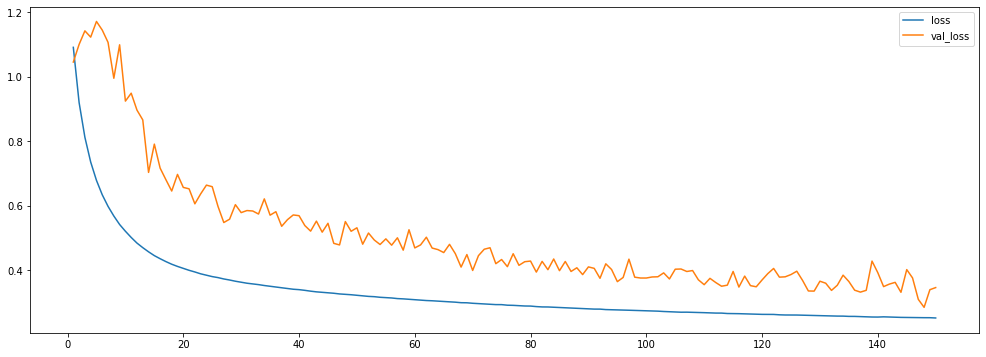

In [116]:
xepochs = range(1, len(log.history['loss']) + 1)
plt.rcParams['figure.figsize'] = (17, 6)
plt.plot(xepochs, log.history['loss'], label = 'loss')
plt.plot(xepochs, log.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

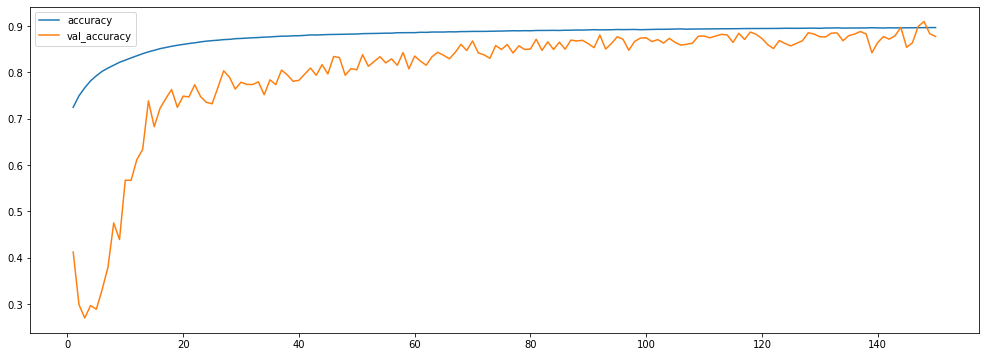

In [117]:
plt.rcParams['figure.figsize'] = (17, 6)
plt.plot(xepochs, log.history['accuracy'], label = 'accuracy')
plt.plot(xepochs, log.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()